# Analysis of the Tcells data (marker stainings)
---

## 0. Environmental setup

In [44]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from scipy.stats import pearsonr

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn import mixture
import itertools

from tqdm import tqdm

from scipy.stats import describe, kruskal

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [45]:
def find_markers(data, labels, k=10, exclude_cols=[]):
    results = []
    labels_unique = np.unique(labels)
    i = 0
    for label in labels_unique:
        label_results = {
            "label": [],
            "marker": [],
            "fc": [],
            "abs_delta_fc": [],
            "pval": [],
        }
        for c in data.columns:
            if c in exclude_cols:
                continue
            i += 1
            x = np.array(data.loc[labels == label, c])
            y = np.array(data.loc[labels != label, c])
            x = np.array(x[x != np.nan]).astype(float)
            y = np.array(y[y != np.nan]).astype(float)

            pval = stats.ranksums(x, y)[1]
            fc = (np.mean(x) + 1e-15) / (np.mean(y) + 1e-15)
            label_results["label"].append(label)
            label_results["marker"].append(c)
            label_results["fc"].append(fc)
            label_results["abs_delta_fc"].append(abs(fc - 1))
            label_results["pval"].append(pval)
        label_result = pd.DataFrame(label_results)
        label_result.pval = label_result.pval.astype(float)
        label_result = label_result.sort_values("pval", ascending=True)
        results.append(label_result.head(k))
    result = pd.concat(results)
    result["fwer_padj"] = result.pval * len(result)
    return result

<IPython.core.display.Javascript object>

In [46]:
def kruskal_screen(data, labels):
    markers = []
    pvals = []
    labels_unique = np.unique(labels)
    features = list(data.columns)
    for feature in tqdm(features, desc="Progress marker screen"):
        samples = [np.array(data.loc[labels == l, feature]) for l in labels_unique]
        pval = kruskal(*samples)[1]
        markers.append(feature)
        pvals.append(pval)
    result = pd.DataFrame({"marker": markers, "pval": pvals})
    result["fwer_padj"] = result.pval / len(markers)
    result = result.sort_values("fwer_padj")
    return result

<IPython.core.display.Javascript object>

---
## 1. Read in data

### 1.1. Fibronectin coating, DAPI/CD8, 12bit

#### 1.1.a. HV1 (M24)

In [47]:
feature_file = "../../data/tcells_hv/dapi_cd8/HV1_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_cd8_features = pd.read_csv(feature_file, index_col=0)

hv1_dapi_cd8_features["sample"] = np.repeat("t_m24_fn_cd8", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["id"] = np.repeat("m24", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["age"] = np.repeat("24", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["sex"] = np.repeat("m", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features["coating"] = np.repeat("fibronectin", len(hv1_dapi_cd8_features))
hv1_dapi_cd8_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd8_3d_int,normalized_q75_cd8_3d_int,normalized_median_cd8_3d_int,normalized_kurtosis_cd8_3d_int,normalized_skewness_cd8_3d_int,sample,id,age,sex,coating
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_0,0.024828,0.056021,47,0.112288,0.051050,0.047379,0.023152,8.065821,158,0.174355,...,0.0,2.764193,2.466658,12.111864,2.139524,t_m24_fn_cd8,m24,24,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_1,0.027005,0.038786,48,0.112288,0.050097,0.037563,0.022328,6.312228,126,0.089717,...,0.0,3.240042,2.603298,0.991777,0.996007,t_m24_fn_cd8,m24,24,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_2,0.024647,0.068218,52,0.134861,0.064814,0.060629,0.028087,9.009083,139,0.217129,...,0.0,3.188688,2.827207,1.479474,0.825498,t_m24_fn_cd8,m24,24,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_3,0.024519,0.067288,39,0.116547,0.056428,0.054669,0.022590,9.310672,165,0.234468,...,0.0,2.949099,2.421397,0.980296,0.940752,t_m24_fn_cd8,m24,24,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_4,0.027653,0.030496,59,0.103945,0.045776,0.037563,0.020020,5.813511,127,0.042304,...,0.0,3.463306,2.995209,-0.883519,0.196742,t_m24_fn_cd8,m24,24,m,fibronectin


<IPython.core.display.Javascript object>

#### 1.1.b. HV2 (M33)

In [48]:
feature_file = "../../data/tcells_hv/dapi_cd8/HV2_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_cd8_features = pd.read_csv(feature_file, index_col=0)

hv2_dapi_cd8_features["sample"] = np.repeat("t_m33_fn_cd8", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["id"] = np.repeat("m33", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["age"] = np.repeat("33", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["sex"] = np.repeat("m", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features["coating"] = np.repeat("fibronectin", len(hv2_dapi_cd8_features))
hv2_dapi_cd8_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd8_3d_int,normalized_q75_cd8_3d_int,normalized_median_cd8_3d_int,normalized_kurtosis_cd8_3d_int,normalized_skewness_cd8_3d_int,sample,id,age,sex,coating
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_0,0.026385,0.038776,65,0.106286,0.049805,0.042304,0.023533,6.175844,124,0.125966,...,0.0,2.940028,2.531691,5.950836,1.555512,t_m33_fn_cd8,m33,33,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_1,0.027973,0.043611,48,0.131710,0.054041,0.047379,0.026437,6.376815,118,0.075943,...,0.0,3.289824,2.711944,0.484362,0.810128,t_m33_fn_cd8,m33,33,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_2,0.026155,0.039424,61,0.106286,0.049263,0.040807,0.021990,6.453431,131,0.116547,...,0.0,2.868976,2.471467,13.892826,2.267971,t_m33_fn_cd8,m33,33,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_3,0.026230,0.034196,67,0.106286,0.046113,0.037563,0.020506,6.086902,132,0.067891,...,0.0,3.171357,2.674638,1.558539,0.927756,t_m33_fn_cd8,m33,33,m,fibronectin
Tcells_Dapi_CD8__CD3_11_5_21_2X_12bit_1_4,0.030266,0.030562,44,0.098052,0.045388,0.037563,0.018158,5.582707,123,0.058785,...,0.0,3.504336,3.174516,2.407180,1.095675,t_m33_fn_cd8,m33,33,m,fibronectin


<IPython.core.display.Javascript object>

----

#### 1.1.c. HV4 (M60)

In [49]:
feature_file = "../../data/tcells_hv/dapi_cd8/HV4_Tcells_DAPI_CD8_CD4_21_5_21_12bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_cd8_features = pd.read_csv(feature_file, index_col=0)

hv4_dapi_cd8_features["sample"] = np.repeat("t_m60_fn_cd8", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["id"] = np.repeat("m60", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["age"] = np.repeat("60", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["sex"] = np.repeat("m", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features["coating"] = np.repeat("fibronectin", len(hv4_dapi_cd8_features))
hv4_dapi_cd8_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd8_3d_int,normalized_q75_cd8_3d_int,normalized_median_cd8_3d_int,normalized_kurtosis_cd8_3d_int,normalized_skewness_cd8_3d_int,sample,id,age,sex,coating
HV3_Tcells_DAPI_CD8_CD3_20_5_21_2X_12bit_1_0,0.022979,0.070005,37,0.153825,0.073759,0.071429,0.031133,9.367413,127,0.174355,...,0.000000,3.308021,2.951163,-1.012823,0.140583,t_m60_fn_cd8,m60,60,m,fibronectin
HV3_Tcells_DAPI_CD8_CD3_20_5_21_2X_12bit_1_1,0.025012,0.039700,64,0.128911,0.047490,0.037563,0.019776,6.885986,145,0.106286,...,0.000000,3.013672,2.665358,1.396587,0.760014,t_m60_fn_cd8,m60,60,m,fibronectin
HV3_Tcells_DAPI_CD8_CD3_20_5_21_2X_12bit_1_2,0.025755,0.049964,55,0.136772,0.059638,0.058785,0.029366,6.977684,117,0.121212,...,0.384543,3.154674,2.777252,37.124946,3.154160,t_m60_fn_cd8,m60,60,m,fibronectin
HV3_Tcells_DAPI_CD8_CD3_20_5_21_2X_12bit_1_3,0.026110,0.058688,59,0.153764,0.059397,0.056727,0.031178,7.602832,128,0.187838,...,0.000000,3.417458,3.098447,-1.037685,0.319992,t_m60_fn_cd8,m60,60,m,fibronectin
HV3_Tcells_DAPI_CD8_CD3_20_5_21_2X_12bit_1_4,0.028580,0.030717,67,0.098052,0.047194,0.037563,0.019262,5.757687,122,0.037563,...,0.000000,3.358423,2.825220,-0.249066,0.625210,t_m60_fn_cd8,m60,60,m,fibronectin


<IPython.core.display.Javascript object>

### 1.2 Polylysine coating, DAPI/CD4, 16bit

#### 1.2.a. HV1 (M24)

In [50]:
feature_file = "../../data/tcells_hv/marker/HV1_Tcells_DAPI_CD4_08_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_cd4_features = pd.read_csv(feature_file, index_col=0)

hv1_dapi_cd4_features["sample"] = np.repeat("t_m24_pl_cd4", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["id"] = np.repeat("m24", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["age"] = np.repeat("24", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["sex"] = np.repeat("m", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features["coating"] = np.repeat("polylysine", len(hv1_dapi_cd4_features))
hv1_dapi_cd4_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd4_3d_int,normalized_q75_cd4_3d_int,normalized_median_cd4_3d_int,normalized_kurtosis_cd4_3d_int,normalized_skewness_cd4_3d_int,sample,id,age,sex,coating
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_0,0.026754,0.060846,50,0.149234,0.067312,0.067891,0.029678,7.875472,117,0.149234,...,0.446258,3.557844,3.116549,-0.357085,0.337222,t_m24_pl_cd4,m24,24,m,polylysine
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_1,0.029061,0.039525,54,0.127919,0.050383,0.047379,0.024390,6.146699,122,0.079597,...,0.000000,3.565711,3.067774,-0.398278,0.221233,t_m24_pl_cd4,m24,24,m,polylysine
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_2,0.028305,0.036048,54,0.098052,0.048600,0.047379,0.019759,6.220828,128,0.067891,...,0.000000,3.433537,3.051810,-0.437914,0.484958,t_m24_pl_cd4,m24,24,m,polylysine
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_3,0.030074,0.041218,36,0.106286,0.050175,0.047379,0.021506,6.271814,125,0.128911,...,0.000000,3.422906,3.135030,-0.080347,0.556444,t_m24_pl_cd4,m24,24,m,polylysine
Tcells_Dapi_CD4_08_07_21_2X_16bit_1_4,0.029102,0.050381,38,0.136772,0.053142,0.047379,0.024919,7.227297,136,0.145756,...,0.251005,3.785557,3.375160,11.358325,1.606088,t_m24_pl_cd4,m24,24,m,polylysine


<IPython.core.display.Javascript object>

#### 1.2.b. HV2 (M33)

In [51]:
feature_file = "../../data/tcells_hv/marker/HV2_Tcells_DAPI_CD4_08_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_cd4_features = pd.read_csv(feature_file, index_col=0)

hv2_dapi_cd4_features["sample"] = np.repeat("t_m33_pl_cd4", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["id"] = np.repeat("m33", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["age"] = np.repeat("33", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["sex"] = np.repeat("m", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features["coating"] = np.repeat("polylysine", len(hv2_dapi_cd4_features))
hv2_dapi_cd4_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd4_3d_int,normalized_q75_cd4_3d_int,normalized_median_cd4_3d_int,normalized_kurtosis_cd4_3d_int,normalized_skewness_cd4_3d_int,sample,id,age,sex,coating
HV2_Tcells_Dapi_CD4_08_07_21_2X_16bit_1_0,0.024334,0.052419,51,0.153825,0.057899,0.058785,0.028779,7.642661,132,0.098052,...,0.422286,3.464085,3.039481,1.739082,0.604062,t_m33_pl_cd4,m33,33,m,polylysine
HV2_Tcells_Dapi_CD4_08_07_21_2X_16bit_1_1,0.027603,0.043169,53,0.127919,0.055300,0.048074,0.024060,6.636037,120,0.071429,...,0.630201,3.526725,3.011808,2.914593,0.784648,t_m33_pl_cd4,m33,33,m,polylysine
HV2_Tcells_Dapi_CD4_08_07_21_2X_16bit_1_2,0.029182,0.070088,40,0.214616,0.061331,0.058785,0.031245,8.463707,138,0.356789,...,0.000000,3.849172,3.493673,3.041354,1.011355,t_m33_pl_cd4,m33,33,m,polylysine
HV2_Tcells_Dapi_CD4_08_07_21_2X_16bit_1_3,0.027211,0.042110,58,0.128911,0.052502,0.037563,0.024847,6.562720,125,0.089717,...,0.000000,3.899433,3.447787,-0.739313,0.473970,t_m33_pl_cd4,m33,33,m,polylysine
HV2_Tcells_Dapi_CD4_08_07_21_2X_16bit_1_4,0.027730,0.047977,57,0.131710,0.060117,0.058785,0.028820,6.853388,114,0.089717,...,0.000000,3.302572,2.928549,4.169661,1.253653,t_m33_pl_cd4,m33,33,m,polylysine


<IPython.core.display.Javascript object>

#### 1.2.c. HV3 (F42)

In [52]:
feature_file = "../../data/tcells_hv/marker/HV3_Tcells_DAPI_CD4_09_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv3_dapi_cd4_features = pd.read_csv(feature_file, index_col=0)

hv3_dapi_cd4_features["sample"] = np.repeat("t_f42_pl_cd4", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["id"] = np.repeat("f42", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["age"] = np.repeat("42", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["sex"] = np.repeat("f", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features["coating"] = np.repeat("polylysine", len(hv3_dapi_cd4_features))
hv3_dapi_cd4_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd4_3d_int,normalized_q75_cd4_3d_int,normalized_median_cd4_3d_int,normalized_kurtosis_cd4_3d_int,normalized_skewness_cd4_3d_int,sample,id,age,sex,coating
HV3_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_0,0.028427,0.040345,45,0.106286,0.049559,0.040807,0.019656,6.442624,130,0.128911,...,0.0,3.249304,2.910544,10.462866,1.488823,t_f42_pl_cd4,f42,42,f,polylysine
HV3_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_1,0.029034,0.037668,56,0.121212,0.054022,0.047379,0.022644,5.726376,106,0.060629,...,0.0,4.065052,3.719122,-1.060940,0.543068,t_f42_pl_cd4,f42,42,f,polylysine
HV3_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_2,0.029846,0.060390,49,0.131710,0.060069,0.058785,0.025471,7.208256,120,0.226699,...,0.0,4.096698,3.732136,0.958864,0.774054,t_f42_pl_cd4,f42,42,f,polylysine
HV3_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_3,0.031298,0.030075,50,0.103945,0.045679,0.037563,0.019377,5.481480,120,0.037563,...,0.0,4.290246,3.778171,-1.143247,0.479666,t_f42_pl_cd4,f42,42,f,polylysine
HV3_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_4,0.026592,0.042251,61,0.106286,0.052490,0.047379,0.023209,6.823734,130,0.067891,...,0.0,3.771563,3.359555,-0.918057,0.556786,t_f42_pl_cd4,f42,42,f,polylysine


<IPython.core.display.Javascript object>

#### 1.2.d. HV4 (M60)

In [53]:
feature_file = "../../data/tcells_hv/marker/HV4_Tcells_DAPI_CD4_09_07_21_16bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_cd4_features = pd.read_csv(feature_file, index_col=0)

hv4_dapi_cd4_features["sample"] = np.repeat("t_m60_pl_cd4", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["id"] = np.repeat("m60", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["age"] = np.repeat("60", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["sex"] = np.repeat("m", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features["coating"] = np.repeat("polylysine", len(hv4_dapi_cd4_features))
hv4_dapi_cd4_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd4_3d_int,normalized_q75_cd4_3d_int,normalized_median_cd4_3d_int,normalized_kurtosis_cd4_3d_int,normalized_skewness_cd4_3d_int,sample,id,age,sex,coating
HV4_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_0,0.029237,0.035371,67,0.102207,0.048452,0.037563,0.020985,6.153345,127,0.060629,...,0.00000,3.944610,3.583055,1.765839,0.797384,t_m60_pl_cd4,m60,60,m,polylysine
HV4_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_1,0.030177,0.043895,61,0.116547,0.051252,0.047379,0.021396,6.457706,126,0.166243,...,0.00000,4.112696,3.758682,-0.806575,0.559946,t_m60_pl_cd4,m60,60,m,polylysine
HV4_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_2,0.028357,0.043194,51,0.153764,0.051938,0.047379,0.026955,6.440304,124,0.116547,...,0.00000,3.506187,3.133203,-0.109668,0.619556,t_m60_pl_cd4,m60,60,m,polylysine
HV4_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_3,0.028235,0.051609,50,0.136772,0.062275,0.059707,0.028913,6.974843,112,0.116547,...,0.48908,3.923489,3.559355,-1.162322,0.172866,t_m60_pl_cd4,m60,60,m,polylysine
HV4_Tcells_Dapi_CD4_09_07_21_2X_16bit_1_4,0.029847,0.038601,44,0.103945,0.052062,0.047379,0.020927,6.039146,116,0.103945,...,0.00000,3.958847,3.589016,2.566533,0.875438,t_m60_pl_cd4,m60,60,m,polylysine


<IPython.core.display.Javascript object>

### 1.3. Fibronectin coating, DAPI/gH2AX/Lamin, 16bit

#### 1.3.a. HV1 (M24)

In [54]:
feature_file = "../../data/tcells_hv/dapi_gh2ax_lamin/HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_gl_features = pd.read_csv(feature_file, index_col=0)


hv1_dapi_gl_features["sample"] = np.repeat("t_m24_gl", len(hv1_dapi_gl_features))
hv1_dapi_gl_features["id"] = np.repeat("m24", len(hv1_dapi_gl_features))
hv1_dapi_gl_features["age"] = np.repeat("24", len(hv1_dapi_gl_features))
hv1_dapi_gl_features["sex"] = np.repeat("m", len(hv1_dapi_gl_features))
hv1_dapi_gl_features["coating"] = np.repeat("fibronectin", len(hv1_dapi_gl_features))
hv1_dapi_gl_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_lamin_3d_int,normalized_q75_lamin_3d_int,normalized_median_lamin_3d_int,normalized_kurtosis_lamin_3d_int,normalized_skewness_lamin_3d_int,sample,id,age,sex,coating
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_0,0.023655,0.050081,48,0.128911,0.058659,0.058785,0.028304,7.508318,128,0.106286,...,0.000000,2.678573,2.274295,29.543864,3.412615,t_m24_gl,m24,24,m,fibronectin
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_1,0.029586,0.054795,60,0.226699,0.056485,0.054669,0.032131,7.399511,131,0.217129,...,0.000000,3.316032,2.848827,0.265629,0.872093,t_m24_gl,m24,24,m,fibronectin
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_2,0.026098,0.044768,71,0.131710,0.054849,0.054669,0.024680,6.856184,125,0.098052,...,0.000000,2.856719,2.412041,16.566869,2.588750,t_m24_gl,m24,24,m,fibronectin
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_3,0.025879,0.031963,60,0.098052,0.046919,0.037563,0.018932,5.864822,125,0.067891,...,0.000000,3.227414,2.752763,-0.128324,0.798750,t_m24_gl,m24,24,m,fibronectin
HV1_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_4,0.027012,0.044294,60,0.131710,0.056660,0.044093,0.026248,6.459187,114,0.116547,...,0.349312,3.366867,2.756622,13.868109,2.108207,t_m24_gl,m24,24,m,fibronectin


<IPython.core.display.Javascript object>

#### 1.3.b. HV2 (M33)

In [55]:
feature_file = "../../data/tcells_hv/dapi_gh2ax_lamin/HV2_Tcells_Dapi_gH2AX__lamin_28_5_21_2X_16bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_gl_features = pd.read_csv(feature_file, index_col=0)

hv2_dapi_gl_features["sample"] = np.repeat("t_m33_fn_gl", len(hv2_dapi_gl_features))
hv2_dapi_gl_features["id"] = np.repeat("m33", len(hv2_dapi_gl_features))
hv2_dapi_gl_features["age"] = np.repeat("33", len(hv2_dapi_gl_features))
hv2_dapi_gl_features["sex"] = np.repeat("m", len(hv2_dapi_gl_features))
hv2_dapi_gl_features["coating"] = np.repeat("fibronectin", len(hv2_dapi_gl_features))
hv2_dapi_gl_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_lamin_3d_int,normalized_q75_lamin_3d_int,normalized_median_lamin_3d_int,normalized_kurtosis_lamin_3d_int,normalized_skewness_lamin_3d_int,sample,id,age,sex,coating
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_0,0.023853,0.041713,62,0.103945,0.049869,0.040807,0.021835,6.832014,137,0.094194,...,0.000000,2.273961,1.909973,118.399456,8.105799,t_m33_fn_gl,m33,33,m,fibronectin
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_1,0.023184,0.031466,91,0.116547,0.042697,0.037563,0.018162,6.233703,146,0.058785,...,0.000000,2.881840,2.403419,1.023397,0.853813,t_m33_fn_gl,m33,33,m,fibronectin
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_2,0.025621,0.038630,64,0.116547,0.050799,0.047379,0.022806,6.400699,126,0.071429,...,0.000000,3.095235,2.615199,0.711076,0.983961,t_m33_fn_gl,m33,33,m,fibronectin
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_3,0.028718,0.042359,54,0.131710,0.055712,0.047379,0.026097,6.351119,114,0.098052,...,0.107165,3.050957,2.605279,27.617754,3.441854,t_m33_fn_gl,m33,33,m,fibronectin
HV2_Tcells_Dapi_gH2AX__lamin_26_5_21_2X_16bit_1_4,0.025781,0.057624,48,0.153825,0.058909,0.054669,0.028348,8.070599,137,0.149234,...,0.000000,3.221744,2.757811,0.044835,0.910208,t_m33_fn_gl,m33,33,m,fibronectin


<IPython.core.display.Javascript object>

#### 1.4.a. HV3 (F42)

In [56]:
feature_file = "../../data/tcells_hv/dapi_gh2ax_lamin/HV3_Tcells_Dapi_gH2AX__lamin_09_06_21_2X_16bit/preprocessed/20210716_180256/nuclear_features.csv"
hv3_dapi_gl_features = pd.read_csv(feature_file, index_col=0)

hv3_dapi_gl_features["sample"] = np.repeat("t_f42_fn_gl", len(hv3_dapi_gl_features))
hv3_dapi_gl_features["id"] = np.repeat("f42", len(hv3_dapi_gl_features))
hv3_dapi_gl_features["age"] = np.repeat("42", len(hv3_dapi_gl_features))
hv3_dapi_gl_features["sex"] = np.repeat("f", len(hv3_dapi_gl_features))
hv3_dapi_gl_features["coating"] = np.repeat("fibronectin", len(hv3_dapi_gl_features))
hv3_dapi_gl_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_lamin_3d_int,normalized_q75_lamin_3d_int,normalized_median_lamin_3d_int,normalized_kurtosis_lamin_3d_int,normalized_skewness_lamin_3d_int,sample,id,age,sex,coating
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_0,0.028092,0.032791,53,0.116547,0.045372,0.037563,0.020756,5.943771,131,0.058785,...,0.000000,2.664032,2.439625,46.970488,4.411990,t_f42_fn_gl,f42,42,f,fibronectin
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_1,0.024450,0.038173,71,0.152808,0.047046,0.037563,0.021821,6.586440,140,0.116547,...,0.000000,2.822841,2.310395,10.081193,1.773987,t_f42_fn_gl,f42,42,f,fibronectin
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_2,0.026500,0.026551,65,0.075943,0.040591,0.037563,0.015163,5.804532,143,0.037563,...,0.276908,2.454441,2.031822,47.732467,4.891762,t_f42_fn_gl,f42,42,f,fibronectin
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_3,0.029165,0.032786,45,0.106286,0.044917,0.037563,0.020060,5.973919,133,0.076800,...,0.000000,1.227638,1.042042,99.166452,9.400559,t_f42_fn_gl,f42,42,f,fibronectin
HV3_Tcells_Dapi_gH2AX__lamin_09_05_21_2X_16bit_1_4,0.025228,0.029815,95,0.089717,0.044286,0.037563,0.017129,5.978638,135,0.047379,...,0.000000,2.184279,1.756624,244.765108,12.012767,t_f42_fn_gl,f42,42,f,fibronectin


<IPython.core.display.Javascript object>

#### 1.3.a. HV4 (M60)

In [57]:
feature_file = "../../data/tcells_hv/dapi_gh2ax_lamin/HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_gl_features = pd.read_csv(feature_file, index_col=0)

hv4_dapi_gl_features["sample"] = np.repeat("t_m60_fn_gl", len(hv4_dapi_gl_features))
hv4_dapi_gl_features["id"] = np.repeat("m60", len(hv4_dapi_gl_features))
hv4_dapi_gl_features["age"] = np.repeat("60", len(hv4_dapi_gl_features))
hv4_dapi_gl_features["sex"] = np.repeat("m", len(hv4_dapi_gl_features))
hv4_dapi_gl_features["coating"] = np.repeat("fibronectin", len(hv4_dapi_gl_features))
hv4_dapi_gl_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_lamin_3d_int,normalized_q75_lamin_3d_int,normalized_median_lamin_3d_int,normalized_kurtosis_lamin_3d_int,normalized_skewness_lamin_3d_int,sample,id,age,sex,coating
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_0,0.023688,0.055434,49,0.153825,0.062887,0.058785,0.034680,7.106185,113,0.106286,...,0.0,2.392481,2.301130,4.272703,1.853652,t_m60_fn_gl,m60,60,m,fibronectin
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_1,0.027276,0.047969,54,0.139167,0.057532,0.058785,0.025577,6.961423,121,0.098052,...,0.0,3.121134,2.675009,1.607518,0.859196,t_m60_fn_gl,m60,60,m,fibronectin
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_2,0.024793,0.029245,69,0.098052,0.039748,0.036495,0.017661,6.041764,152,0.098052,...,0.0,2.992712,2.519536,-0.439313,0.745298,t_m60_fn_gl,m60,60,m,fibronectin
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_1_3,0.025059,0.050816,54,0.139167,0.055858,0.054669,0.028015,7.317416,131,0.131710,...,0.0,2.451823,2.190236,64.460161,5.349736,t_m60_fn_gl,m60,60,m,fibronectin
HV4_Tcells_Dapi_gH2AX__lamin_31_5_21_2X_16bit_2_0,0.026173,0.039163,50,0.106286,0.048143,0.040807,0.020883,6.547432,136,0.098052,...,0.0,2.528840,2.077104,23.297882,3.398006,t_m60_fn_gl,m60,60,m,fibronectin


<IPython.core.display.Javascript object>

### 1.5. Fibronectin, PBMC, DAPI/CD45, 16bit

In [58]:
feature_file = "../../data/pbmc_hv/marker/HV1_PBMC_DAPI_CD45_16_6_21_16bit/preprocessed/ia/nuclear_features.csv"
hv1_dapi_cd45_features = pd.read_csv(feature_file, index_col=0)

hv1_dapi_cd45_features["sample"] = np.repeat(
    "p_m24_fn_cd45", len(hv1_dapi_cd45_features)
)
hv1_dapi_cd45_features["id"] = np.repeat("m24", len(hv1_dapi_cd45_features))
hv1_dapi_cd45_features["age"] = np.repeat("24", len(hv1_dapi_cd45_features))
hv1_dapi_cd45_features["sex"] = np.repeat("m", len(hv1_dapi_cd45_features))
hv1_dapi_cd45_features["coating"] = np.repeat(
    "fibronectin", len(hv1_dapi_cd45_features)
)
hv1_dapi_cd45_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd45_3d_int,normalized_q75_cd45_3d_int,normalized_median_cd45_3d_int,normalized_kurtosis_cd45_3d_int,normalized_skewness_cd45_3d_int,sample,id,age,sex,coating
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_0,0.022172,0.059912,53,0.149234,0.066085,0.060629,0.033908,8.392756,127,0.127626,...,0.000000,3.349500,3.071702,-0.998240,0.219474,p_m24_fn_cd45,m24,24,m,fibronectin
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_1,0.021686,0.055390,76,0.139167,0.057745,0.054669,0.028504,8.142023,141,0.153825,...,0.000000,3.059549,2.836056,-0.864841,0.380893,p_m24_fn_cd45,m24,24,m,fibronectin
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_2,0.028951,0.045471,56,0.116547,0.052786,0.047379,0.023464,6.598282,125,0.153825,...,0.000000,0.830963,0.732344,7.557166,2.983581,p_m24_fn_cd45,m24,24,m,fibronectin
PBMC_Dapi_CD45_16_6_21_2X_16bit_1_3,0.023076,0.069628,56,0.160425,0.067599,0.067891,0.029564,9.734251,144,0.268823,...,0.393176,3.193074,3.192976,-1.243038,-0.801551,p_m24_fn_cd45,m24,24,m,fibronectin
PBMC_Dapi_CD45_16_6_21_2X_16bit_2_0,0.024892,0.070354,46,0.153825,0.068799,0.060629,0.035529,9.150270,133,0.196091,...,0.000000,3.190441,2.623936,-0.497262,0.452738,p_m24_fn_cd45,m24,24,m,fibronectin


<IPython.core.display.Javascript object>

In [59]:
feature_file = "../../data/pbmc_hv/marker/HV2_PBMC_DAPI_CD45_24_6_21_16bit/preprocessed/ia/nuclear_features.csv"
hv2_dapi_cd45_features = pd.read_csv(feature_file, index_col=0)

hv2_dapi_cd45_features["sample"] = np.repeat(
    "p_m33_fn_cd45", len(hv2_dapi_cd45_features)
)
hv2_dapi_cd45_features["id"] = np.repeat("m33", len(hv2_dapi_cd45_features))
hv2_dapi_cd45_features["age"] = np.repeat("33", len(hv2_dapi_cd45_features))
hv2_dapi_cd45_features["sex"] = np.repeat("m", len(hv2_dapi_cd45_features))
hv2_dapi_cd45_features["coating"] = np.repeat(
    "fibronectin", len(hv2_dapi_cd45_features)
)
hv2_dapi_cd45_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd45_3d_int,normalized_q75_cd45_3d_int,normalized_median_cd45_3d_int,normalized_kurtosis_cd45_3d_int,normalized_skewness_cd45_3d_int,sample,id,age,sex,coating
HV2_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_0,0.028028,0.047091,35,0.106286,0.046838,0.037563,0.021741,6.885180,147,0.196091,...,0.000000,2.783241,2.553201,250.308765,11.209292,p_m33_fn_cd45,m33,33,m,fibronectin
HV2_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_1,0.028100,0.048330,61,0.145756,0.056250,0.054669,0.026379,6.749990,120,0.145756,...,0.000000,3.371766,3.098687,29.152917,2.878887,p_m33_fn_cd45,m33,33,m,fibronectin
HV2_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_2,0.028362,0.046163,51,0.127919,0.053826,0.047379,0.025656,6.674457,124,0.150000,...,0.236974,3.288488,2.892358,17.363014,2.797304,p_m33_fn_cd45,m33,33,m,fibronectin
HV2_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_3,0.027525,0.053935,60,0.200704,0.059245,0.054669,0.032890,7.050194,119,0.157067,...,0.274246,3.525652,3.144185,0.326927,0.391720,p_m33_fn_cd45,m33,33,m,fibronectin
HV2_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_4,0.026816,0.054705,50,0.128911,0.062750,0.058785,0.027539,7.529969,120,0.136772,...,0.000000,3.378499,3.047330,2.303413,0.726455,p_m33_fn_cd45,m33,33,m,fibronectin


<IPython.core.display.Javascript object>

In [60]:
feature_file = "../../data/pbmc_hv/marker/HV4_PBMC_DAPI_CD45_24_6_21_16bit/preprocessed/ia/nuclear_features.csv"
hv4_dapi_cd45_features = pd.read_csv(feature_file, index_col=0)

hv4_dapi_cd45_features["sample"] = np.repeat(
    "p_m60_fn_cd45", len(hv4_dapi_cd45_features)
)
hv4_dapi_cd45_features["id"] = np.repeat("m60", len(hv4_dapi_cd45_features))
hv4_dapi_cd45_features["age"] = np.repeat("60", len(hv4_dapi_cd45_features))
hv4_dapi_cd45_features["sex"] = np.repeat("m", len(hv4_dapi_cd45_features))
hv4_dapi_cd45_features["coating"] = np.repeat(
    "fibronectin", len(hv4_dapi_cd45_features)
)
hv4_dapi_cd45_features.head()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,normalized_q25_cd45_3d_int,normalized_q75_cd45_3d_int,normalized_median_cd45_3d_int,normalized_kurtosis_cd45_3d_int,normalized_skewness_cd45_3d_int,sample,id,age,sex,coating
HV4_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_0,0.029902,0.033230,43,0.103945,0.049935,0.037563,0.020806,5.492801,110,0.037563,...,0.0,4.003905,3.686247,-0.764147,0.539128,p_m60_fn_cd45,m60,60,m,fibronectin
HV4_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_1,0.027600,0.052584,54,0.153825,0.055438,0.040807,0.028694,7.206882,130,0.153825,...,0.0,3.656838,3.154240,-1.378322,0.029480,p_m60_fn_cd45,m60,60,m,fibronectin
HV4_PBMC_Dapi_CD45_23_6_21_2X_16bit_1_2,0.026427,0.055511,56,0.181589,0.061063,0.058785,0.032260,7.266549,119,0.173950,...,0.0,1.984388,1.865400,206.824550,12.196486,p_m60_fn_cd45,m60,60,m,fibronectin
HV4_PBMC_Dapi_CD45_23_6_21_2X_16bit_2_0,0.027717,0.048132,49,0.106286,0.054986,0.054669,0.023733,7.093135,129,0.125562,...,0.0,3.590948,3.317208,2.145965,1.070653,p_m60_fn_cd45,m60,60,m,fibronectin
HV4_PBMC_Dapi_CD45_23_6_21_2X_16bit_2_1,0.028082,0.038443,44,0.103945,0.050648,0.047379,0.020016,6.077818,120,0.079597,...,0.0,3.576075,3.022407,-1.048688,0.368021,p_m60_fn_cd45,m60,60,m,fibronectin


<IPython.core.display.Javascript object>

### 1.4 All data

In [61]:
all_data = (
    hv1_dapi_cd8_features.append(hv2_dapi_cd8_features)
    .append(hv4_dapi_cd8_features)
    .append(hv1_dapi_cd4_features)
    .append(hv2_dapi_cd4_features)
    .append(hv3_dapi_cd4_features)
    .append(hv4_dapi_cd4_features)
    .append(hv1_dapi_gl_features)
    .append(hv2_dapi_gl_features)
    .append(hv3_dapi_gl_features)
    .append(hv4_dapi_gl_features)
    .append(hv1_dapi_cd45_features)
    .append(hv2_dapi_cd45_features)
    .append(hv4_dapi_cd45_features)
)
all_data.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Max_posi_Curvature,Avg_posi_Curvature,Med_posi_Curvature,Std_posi_Curvature,Sum_posi_Curvature,Len_posi_Curvature,Max_neg_Curvature,...,median_cd45_3d_int,kurtosis_cd45_3d_int,skewness_cd45_3d_int,normalized_mean_cd45_3d_int,normalized_std_cd45_3d_int,normalized_q25_cd45_3d_int,normalized_q75_cd45_3d_int,normalized_median_cd45_3d_int,normalized_kurtosis_cd45_3d_int,normalized_skewness_cd45_3d_int
count,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,...,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000
mean,0.027575,0.048397,54.500180,0.135982,0.056039,0.050572,0.026325,7.074684,126.269982,0.129357,...,9353.171736,17.166585,1.773742,2.889214,1.646071,0.040520,3.332958,3.025494,17.166585,1.773742
std,0.002727,0.016020,13.592843,0.051055,0.011467,0.012093,0.008839,1.750095,13.149842,0.066679,...,15496.560158,41.551197,2.364928,0.422083,0.447800,0.120339,0.660771,0.621697,41.551196,2.364928
min,-0.001781,0.021762,25.000000,0.075943,0.038411,0.033706,0.013744,4.960635,50.000000,0.027695,...,913.000000,-1.852287,-1.104467,0.890293,0.127370,0.000000,0.527668,0.477568,-1.852287,-1.104468
25%,0.026413,0.038222,47.000000,0.106286,0.049968,0.040807,0.021708,6.200869,120.000000,0.076800,...,2061.000000,-0.926059,0.429028,2.784100,1.361176,0.000000,3.097602,2.818125,-0.926059,0.429028
50%,0.027753,0.045578,53.000000,0.127919,0.054136,0.047379,0.024633,6.684959,125.000000,0.116547,...,2779.000000,2.495559,0.942387,2.970510,1.664485,0.000000,3.461132,3.167281,2.495558,0.942386
75%,0.028956,0.054689,59.000000,0.142434,0.059210,0.058785,0.028282,7.372648,131.000000,0.158717,...,4982.000000,15.965658,2.220875,3.111719,1.864890,0.000000,3.720124,3.393841,15.965655,2.220874
max,0.070115,0.182444,239.000000,0.585786,0.207496,0.205785,0.107856,31.891961,285.000000,0.500000,...,65535.000000,420.599640,17.563793,4.807116,3.404287,1.228148,5.283892,4.886009,420.599534,17.563795


<IPython.core.display.Javascript object>

In [62]:
list(all_data.columns)

['Avg_Curvature',
 'Std_Curvature',
 'nPolarity_changes',
 'Max_posi_Curvature',
 'Avg_posi_Curvature',
 'Med_posi_Curvature',
 'Std_posi_Curvature',
 'Sum_posi_Curvature',
 'Len_posi_Curvature',
 'Max_neg_Curvature',
 'Avg_neg_Curvature',
 'Med_neg_Curvature',
 'Std_neg_Curvature',
 'Sum_neg_Curvature',
 'Len_neg_Curvature',
 'num_prominant_positive_curvature',
 'prominance_prominant_positive_curvature',
 'width_prominant_positive_curvature',
 'prominant_positive_curvature',
 'num_prominant_negative_curvature',
 'prominance_prominant_negative_curvature',
 'width_prominant_negative_curvature',
 'prominant_negative_curvature',
 'Min_Calliper',
 'Max_Calliper',
 'Min_Radius',
 'Max_Radius',
 'Med_Radius',
 'Avg_Radius',
 'Mode_Radius',
 'D25_Radius',
 'D75_Radius',
 'Std_Radius',
 'Feret_Max',
 'Int_Min',
 'Int_d25',
 'Int_Median',
 'Int_d75',
 'Int_Max',
 'Int_Mean',
 'Int_Mode',
 'Int_SD',
 'Entropy',
 'I80_I20',
 'nHigh_nLow',
 'HC_area_EC_area',
 'HC_area_Nuc_area',
 'HC_content_EC_c

<IPython.core.display.Javascript object>

In [63]:
sample_labels = all_data.loc[:, "sample"]
coating_labels = all_data.loc[:, "coating"]
sample_changes = list(Counter(sample_labels).values())

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

We will now preprocess the data for the downstream analyses.

### 2.1. Remove constant and NA samples

In [64]:
# Remove constant features for control data
cleaned_all_data = all_data.loc[:, (all_data != all_data.iloc[0]).any()]
cleaned_all_data = cleaned_all_data.dropna(axis=1, how="any")
# Remove rows with missing entries in the control data
cleaned_all_data = cleaned_all_data.dropna(axis=0)
print(
    "{} rows and {} columns were dropped for the control data.".format(
        str(len(all_data) - len(cleaned_all_data)),
        str(len(all_data.columns) - len(cleaned_all_data.columns)),
    )
)

0 rows and 184 columns were dropped for the control data.


<IPython.core.display.Javascript object>

### 2.2. Remove highly correlated features


In [71]:
# Maintain features that have at most a Pearson correlation of 0.75
threshold = 0.8

# Control data
all_data_corr_matrix = cleaned_all_data.corr().abs()
upper = all_data_corr_matrix.where(
    np.triu(np.ones(all_data_corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation greater than 0.8
to_drop = (
    [column for column in upper.columns if any(upper[column] > threshold)]
    + ["label"]
    + ["bbox-0"]
    + ["bbox-1"]
    + ["sample"]
    + ["age"]
    + ["sex"]
    + ["orientation"]
    + ["coating"]
    + ["id"]
)
len(to_drop)

175

<IPython.core.display.Javascript object>

In [72]:
for c in cleaned_all_data.columns:
    if "int" in c:
        to_drop.append(c)

<IPython.core.display.Javascript object>

We drop 140 of the features that show a high autocorrelation (larger than 0.8) plus 7 that are additionally excluded as they describe some metainformation.

In [73]:
cleaned_all_features = cleaned_all_data.drop(to_drop, axis=1)
cleaned_all_features.describe()

,Avg_Curvature,Std_Curvature,nPolarity_changes,Len_posi_Curvature,Med_neg_Curvature,num_prominant_positive_curvature,num_prominant_negative_curvature,Min_Calliper,Max_Calliper,Min_Radius,...,moments_central-0-1,moments_central-1-0,moments_central-2-3,Center_Mismatch,Frac_Peri_w_posi_curvature,Frac_Peri_w_polarity_changes,equivalent_diameter.1,extent,solidity,rdp_1
count,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,...,8.345000e+03,8.345000e+03,8.345000e+03,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000,8345.000000
mean,0.027575,0.048397,54.500180,126.269982,0.040483,5.657519,4.661474,60.062073,73.095626,25.381483,...,2.486748e-13,1.413358e-13,-4.274151e+07,0.583301,0.558243,0.239421,37.700904,0.478510,0.861277,0.003744
std,0.002727,0.016020,13.592843,13.149842,0.012594,1.954700,2.023077,6.396437,6.814746,4.850782,...,1.461369e-11,3.053471e-11,1.120849e+09,0.539132,0.035641,0.040701,1.940804,0.052553,0.049290,0.004523
min,-0.001781,0.021762,25.000000,50.000000,0.016151,0.000000,0.000000,20.000000,35.000000,0.031339,...,-8.628831e-11,-2.139302e-10,-2.427385e+10,0.005732,0.290692,0.111175,15.699299,0.176496,0.450434,0.000003
25%,0.026413,0.038222,47.000000,120.000000,0.033706,4.000000,3.000000,56.000000,69.000000,23.100882,...,-8.295586e-12,-2.123812e-11,-2.040204e+08,0.298345,0.537690,0.211586,36.705227,0.452944,0.846991,0.000802
50%,0.027753,0.045578,53.000000,125.000000,0.037563,6.000000,5.000000,60.000000,72.000000,25.978127,...,1.776357e-13,4.547474e-13,-1.363300e+07,0.474355,0.560085,0.237477,37.540404,0.482013,0.873122,0.002500
75%,0.028956,0.054689,59.000000,131.000000,0.039730,7.000000,6.000000,64.000000,75.000000,28.495734,...,8.881784e-12,2.142997e-11,1.671470e+08,0.715737,0.581410,0.264856,38.471196,0.511155,0.891136,0.004970
max,0.070115,0.182444,239.000000,285.000000,0.181936,14.000000,12.000000,86.000000,148.000000,41.343125,...,1.031850e-10,1.855369e-10,3.291395e+10,10.743455,0.663333,0.435651,51.247982,0.658280,0.944320,0.084341


<IPython.core.display.Javascript object>

In [74]:
set(cleaned_all_features.columns)

{'Avg_Curvature',
 'Center_Mismatch',
 'Entropy',
 'Frac_Peri_w_polarity_changes',
 'Frac_Peri_w_posi_curvature',
 'HC_area_EC_area',
 'I80_I20',
 'Int_Min',
 'Int_d25',
 'Len_posi_Curvature',
 'Max_Calliper',
 'Med_neg_Curvature',
 'Min_Calliper',
 'Min_Radius',
 'Std_Curvature',
 'Std_Radius',
 'correlation_1',
 'correlation_20',
 'dissimilarity_1',
 'eccentricity',
 'equivalent_diameter.1',
 'extent',
 'moments_central-0-1',
 'moments_central-1-0',
 'moments_central-2-3',
 'moments_normalized-0-2',
 'moments_normalized-2-0',
 'moments_normalized-2-2',
 'nHigh_nLow',
 'nPolarity_changes',
 'num_prominant_negative_curvature',
 'num_prominant_positive_curvature',
 'rdp_1',
 'solidity',
 'weighted_moments-0-0',
 'weighted_moments_central-0-1',
 'weighted_moments_central-0-3',
 'weighted_moments_central-1-0',
 'weighted_moments_central-1-1',
 'weighted_moments_central-1-2',
 'weighted_moments_central-2-1',
 'weighted_moments_central-2-3',
 'weighted_moments_central-3-0',
 'weighted_momen

<IPython.core.display.Javascript object>

---

## 3. Data visualization

We will now visualize the cleaned data that consists of 57 features after our filtering and 8345 cells from 4 different experiments with 3 different biological samples each.

In [75]:
random.seed(1234)
tsne = TSNE(n_components=2, random_state=1234)
scaled_cleaned_all_features = StandardScaler().fit_transform(cleaned_all_features)
tsne_embedded_cleaned_features = tsne.fit_transform(scaled_cleaned_all_features)

<IPython.core.display.Javascript object>

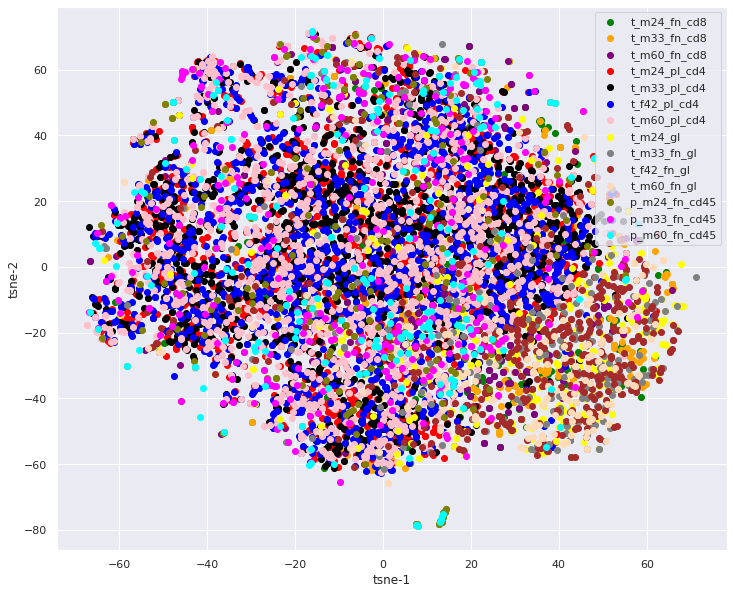

<IPython.core.display.Javascript object>

In [76]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[:, 0]
y = tsne_embedded_cleaned_features[:, 1]
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
colors = [
    "green",
    "orange",
    "purple",
    "red",
    "black",
    "blue",
    "pink",
    "yellow",
    "gray",
    "brown",
    "peachpuff",
    "olive",
    "magenta",
    "cyan",
]
j = 0
for i in range(len(sample_changes)):
    end = j + sample_changes[i]
    scatter = ax.scatter(
        x[j:end],
        y[j:end],
        c=colors[i],
        label=list((Counter(sample_labels)).keys())[i],
    )
    j = end
# ax.set_xlim([-40, 40])
ax.legend()
plt.show()

In [77]:
idc = []
for i in range(len(sample_labels)):
    label = sample_labels[i]
    if "t_" in label:
        idc.append(i)

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


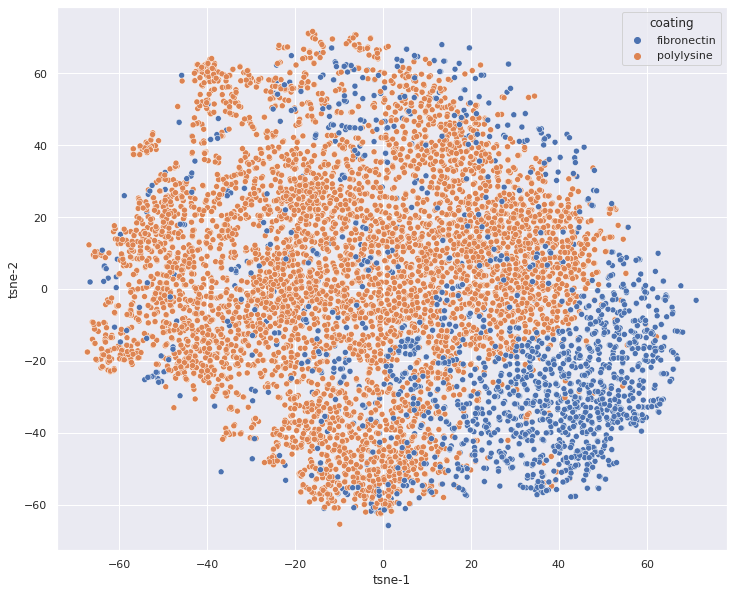

<IPython.core.display.Javascript object>

In [78]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[idc, 0]
y = tsne_embedded_cleaned_features[idc, 1]
sns.scatterplot(x, y, hue=coating_labels[idc])
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
plt.show()

When looking at the above plot, we see that the samples stained with group together mostly with respect to the different coating types. We will now look at the three biological replicates individually to confirm this impression from the aggregated data.

In [79]:
idc = []
for i in range(len(sample_labels)):
    if "m24" in sample_labels[i]:
        idc.append(i)

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


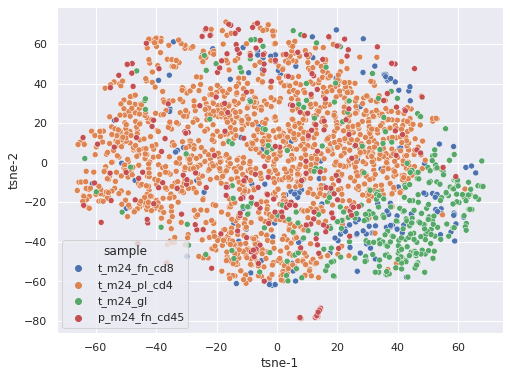

<IPython.core.display.Javascript object>

In [80]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[idc, 0]
y = tsne_embedded_cleaned_features[idc, 1]
sns.scatterplot(
    x,
    y,
    hue=sample_labels[idc],
)
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
plt.show()

In [81]:
idc = []
for i in range(len(sample_labels)):
    if "m33" in sample_labels[i]:
        idc.append(i)

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


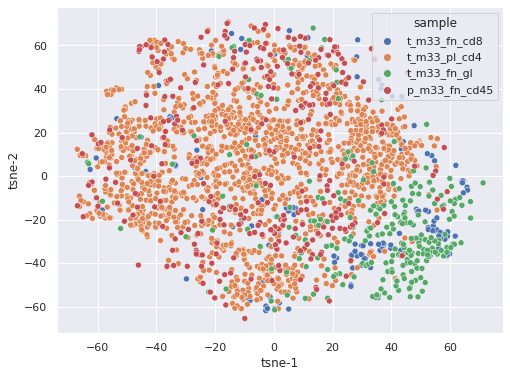

<IPython.core.display.Javascript object>

In [82]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[idc, 0]
y = tsne_embedded_cleaned_features[idc, 1]
sns.scatterplot(
    x,
    y,
    hue=sample_labels[idc],
)
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
plt.show()

In [83]:
idc = []
for i in range(len(sample_labels)):
    if "m60" in sample_labels[i]:
        idc.append(i)

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


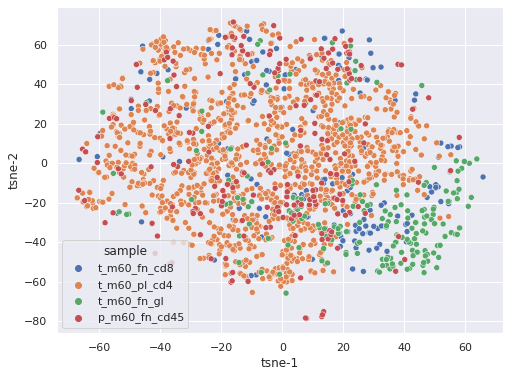

<IPython.core.display.Javascript object>

In [84]:
sns.set(style="darkgrid")

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

x = tsne_embedded_cleaned_features[idc, 0]
y = tsne_embedded_cleaned_features[idc, 1]
sns.scatterplot(
    x,
    y,
    hue=sample_labels[idc],
)
ax.set_xlabel("tsne-1")
ax.set_ylabel("tsne-2")
plt.show()

We see that the population of T cells from the samples that were coated with fibronectin seem to be enriched in the lower right of the overall population. Interestingly, the PBMC data set with fibronectin coating seems to span the whole space of the T cell populations yet not bring up any individual clusters. This might be partly due to the small sample size of PBMC cells. The results suggest that a certain subpopulation of the T cells gets enriched when using fibronectin coating, whereas the unspecific poly-L-lysine coating seems to attach to all cells. This might indicate that a certain subpopulation of T cells better attaches to fibronectin than others.

## 4. T cells primed for attaching to fibronectin

To characterize this subpopulation, we run Wilcoxon-rank sum test-based marker screen to identify the features that are the most differently expressed. To this end, we will run the screen for each biological sample HV1, HV2 and HV4 individually and exclude the 12 bit data set to avoid any confounding of the results due to the different imaging depth.

In [85]:
t_cell_idc = []
for i in range(len(sample_labels)):
    if "t_" in sample_labels[i]:
        t_cell_idc.append(i)
cleaned_all_data["cell_type"] = np.repeat("pbmc", len(cleaned_all_data))
cleaned_all_data.iloc[
    t_cell_idc, list(cleaned_all_data.columns).index("cell_type")
] = "tc"

<IPython.core.display.Javascript object>

In [86]:
hv1_tcell_idc = []
hv2_tcell_idc = []
hv4_tcell_idc = []
for idx in t_cell_idc:
    sample = sample_labels[idx]
    if "m24" in sample:
        hv1_tcell_idc.append(idx)
    elif "m33" in sample:
        hv2_tcell_idc.append(idx)
    elif "m60" in sample:
        hv4_tcell_idc.append(idx)

hv1_t_cell_features = cleaned_all_features.iloc[hv1_tcell_idc, :]
hv2_t_cell_features = cleaned_all_features.iloc[hv2_tcell_idc, :]
hv4_t_cell_features = cleaned_all_features.iloc[hv4_tcell_idc, :]

<IPython.core.display.Javascript object>

#### HV1: M24

In [87]:
coating_marker_screen_results = find_markers(
    hv1_t_cell_features, np.array(coating_labels)[hv1_tcell_idc], k=20
)
coating_marker_screen_results.head(10)

,label,marker,fc,abs_delta_fc,pval,fwer_padj
21,fibronectin,weighted_moments-0-0,1.279144,0.279144,1.781843e-167,7.127372e-166
7,fibronectin,Min_Calliper,1.110835,0.110835,1.281989e-98,5.127955e-97
8,fibronectin,Max_Calliper,1.075734,0.075734,1.395997e-87,5.583990e-86
9,fibronectin,Min_Radius,1.167112,0.167112,2.629616e-86,1.051846e-84
0,fibronectin,Avg_Curvature,0.932603,0.067397,6.498562e-82,2.599425e-80
17,fibronectin,dissimilarity_1,1.107398,0.107398,3.024655e-73,1.209862e-71
54,fibronectin,extent,1.090652,0.090652,2.352531e-63,9.410124e-62
3,fibronectin,Len_posi_Curvature,1.057053,0.057053,1.911815e-53,7.647259e-52
2,fibronectin,nPolarity_changes,1.145143,0.145143,9.730184e-49,3.892074e-47
14,fibronectin,I80_I20,1.023847,0.023847,8.667237e-37,3.466895e-35


<IPython.core.display.Javascript object>

#### HV2: M33

In [88]:
coating_marker_screen_results = find_markers(
    hv2_t_cell_features, np.array(coating_labels)[hv2_tcell_idc], k=20
)
coating_marker_screen_results.head(10)

,label,marker,fc,abs_delta_fc,pval,fwer_padj
21,fibronectin,weighted_moments-0-0,1.333778,0.333778,1.331316e-153,5.325263e-152
7,fibronectin,Min_Calliper,1.121110,0.121110,3.700786e-86,1.480314e-84
9,fibronectin,Min_Radius,1.192769,0.192769,4.902035e-85,1.960814e-83
8,fibronectin,Max_Calliper,1.089100,0.089100,1.052430e-79,4.209721e-78
0,fibronectin,Avg_Curvature,0.928485,0.071515,1.976130e-73,7.904522e-72
17,fibronectin,dissimilarity_1,1.111427,0.111427,1.861686e-66,7.446743e-65
53,fibronectin,equivalent_diameter.1,1.046527,0.046527,7.623277e-62,3.049311e-60
2,fibronectin,nPolarity_changes,1.208538,0.208538,1.503287e-61,6.013149e-60
3,fibronectin,Len_posi_Curvature,1.061515,0.061515,1.420951e-49,5.683806e-48
54,fibronectin,extent,1.074671,0.074671,2.147791e-41,8.591166e-40


<IPython.core.display.Javascript object>

#### HV4: M60

In [89]:
coating_marker_screen_results = find_markers(
    hv4_t_cell_features, np.array(coating_labels)[hv4_tcell_idc], k=20
)
coating_marker_screen_results.head(10)

,label,marker,fc,abs_delta_fc,pval,fwer_padj
21,fibronectin,weighted_moments-0-0,1.297383,0.297383,1.825016e-137,7.300064e-136
17,fibronectin,dissimilarity_1,1.148142,0.148142,2.813113e-92,1.125245e-90
8,fibronectin,Max_Calliper,1.084925,0.084925,5.309249e-75,2.123700e-73
0,fibronectin,Avg_Curvature,0.925443,0.074557,2.172960e-70,8.691841e-69
7,fibronectin,Min_Calliper,1.101299,0.101299,1.618620e-66,6.474481e-65
14,fibronectin,I80_I20,1.030026,0.030026,3.762826e-49,1.505131e-47
9,fibronectin,Min_Radius,1.146347,0.146347,9.253491e-44,3.701396e-42
28,fibronectin,weighted_moments_normalized-2-2,0.782832,0.217168,1.862550e-32,7.450202e-31
12,fibronectin,Int_d25,1.087591,0.087591,2.247020e-28,8.988078e-27
3,fibronectin,Len_posi_Curvature,1.044374,0.044374,2.733849e-28,1.093540e-26


<IPython.core.display.Javascript object>

We see that for all samples curvature and boundary features seem to dominate the set features that show the lowest FWER.


In [90]:
tcell_data = cleaned_all_data.loc[cleaned_all_data["cell_type"] == "tc"]

<IPython.core.display.Javascript object>

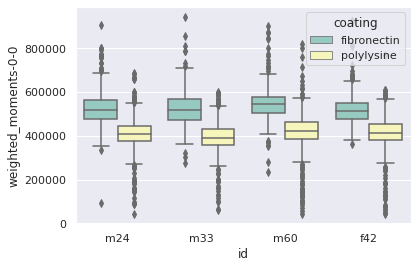

<IPython.core.display.Javascript object>

In [92]:
ax = sns.boxplot(
    x="id", y="weighted_moments-0-0", hue="coating", data=tcell_data, palette="Set3"
)

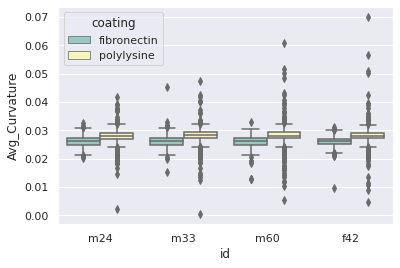

<IPython.core.display.Javascript object>

In [93]:
ax = sns.boxplot(
    x="id", y="Avg_Curvature", hue="coating", data=tcell_data, palette="Set3"
)

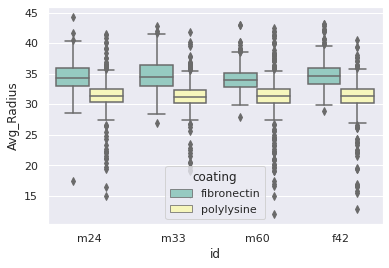

<IPython.core.display.Javascript object>

In [95]:
ax = sns.boxplot(x="id", y="Avg_Radius", hue="coating", data=tcell_data, palette="Set3")

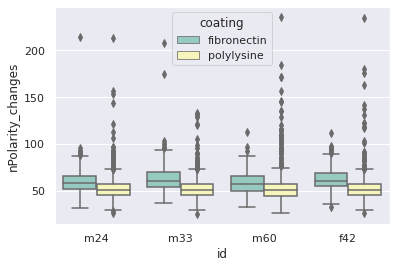

<IPython.core.display.Javascript object>

In [98]:
ax = sns.boxplot(
    x="id", y="nPolarity_changes", hue="coating", data=tcell_data, palette="Set3"
)

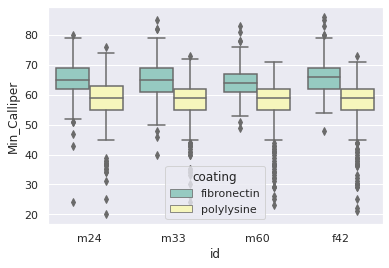

<IPython.core.display.Javascript object>

In [100]:
ax = sns.boxplot(
    x="id", y="Min_Calliper", hue="coating", data=tcell_data, palette="Set3"
)

Jointly, this suggests that the coating has a important influence on the nuclear morphology and chromatin organization and thus it should be kept constant between experiments if one wants to draw conclusions from multiple experiments. Note that also the imaging depth differs between the batches with 12bit for the fibronectin coating and 16bit for the polylysine data.

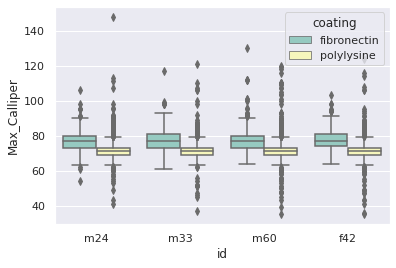

<IPython.core.display.Javascript object>

In [101]:
ax = sns.boxplot(
    x="id", y="Max_Calliper", hue="coating", data=tcell_data, palette="Set3"
)

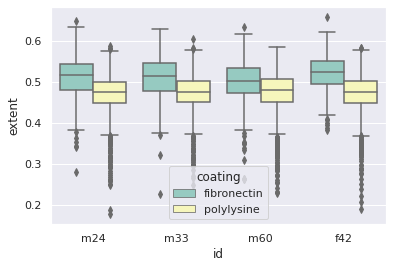

<IPython.core.display.Javascript object>

In [102]:
ax = sns.boxplot(x="id", y="extent", hue="coating", data=tcell_data, palette="Set3")

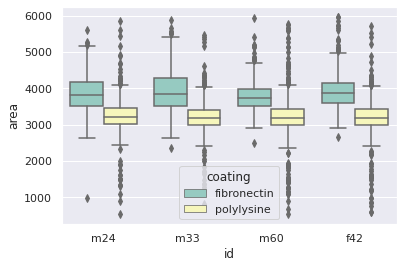

<IPython.core.display.Javascript object>

In [104]:
ax = sns.boxplot(x="id", y="area", hue="coating", data=tcell_data, palette="Set3")